Epoch 1/50


C:\Users\srust\AppData\Local\Temp\ipykernel_20956\484906757.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pm25 = df["PM2.5"].fillna(method="ffill").fillna(method="bfill")
C:\Users\srust\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


904/904 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0397 - val_loss: 0.0197
Epoch 2/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0238 - val_loss: 0.0102
Epoch 3/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0146 - val_loss: 0.0056
Epoch 4/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0104 - val_loss: 0.0043
Epoch 5/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0088 - val_loss: 0.0039
Epoch 6/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0080 - val_loss: 0.0035
Epoch 7/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0072 - val_loss: 0.0030
Epoch 8/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 9/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 10/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 11/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 12/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - los

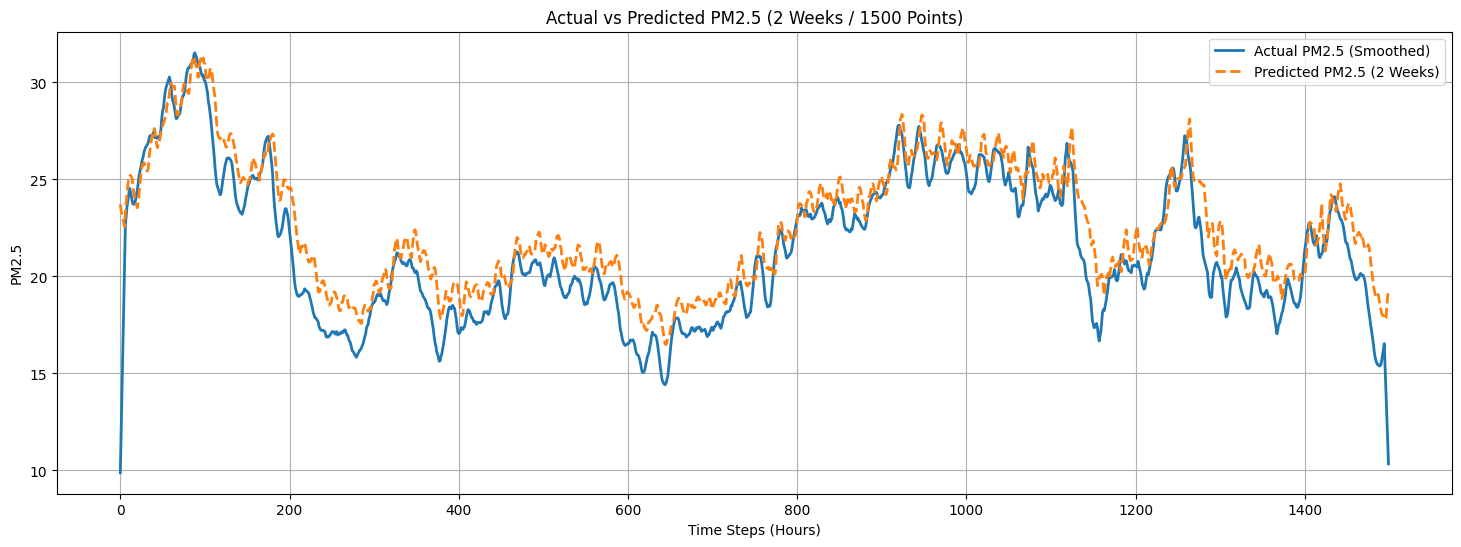

In [3]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


df = pd.read_csv(r'C:\Users\srust\Downloads\air-quality-india.csv')
df = df.sort_values(by=df.columns[0])

pm25 = df["PM2.5"].fillna(method="ffill").fillna(method="bfill")
pm25 = pm25.values.reshape(-1, 1).astype("float32")


scaler = MinMaxScaler()
pm25_scaled = scaler.fit_transform(pm25)


WINDOW = 37

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(pm25_scaled, WINDOW)


split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


model = Sequential([
    LSTM(9, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="mse"
)


model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


POINTS = 1500


POINTS = min(POINTS, len(y_pred))

y_pred_1500 = y_pred[:POINTS]
y_actual_1500 = y_actual[:POINTS]

def moving_average(data, window=12):
    data = data.flatten()
    return np.convolve(data, np.ones(window)/window, mode="same")

SMOOTH_WINDOW = 12   

y_actual_smooth = moving_average(y_actual_1500, SMOOTH_WINDOW)


plt.figure(figsize=(18,6))

plt.plot(
    y_actual_smooth,
    label="Actual PM2.5 ",
    linewidth=2
)

plt.plot(
    y_pred_1500,
    label="Predicted PM2.5 (2 Weeks)",
    linestyle="--",
    linewidth=2
)

plt.title("Actual vs Predicted PM2.5 (2 Week")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)
plt.show()



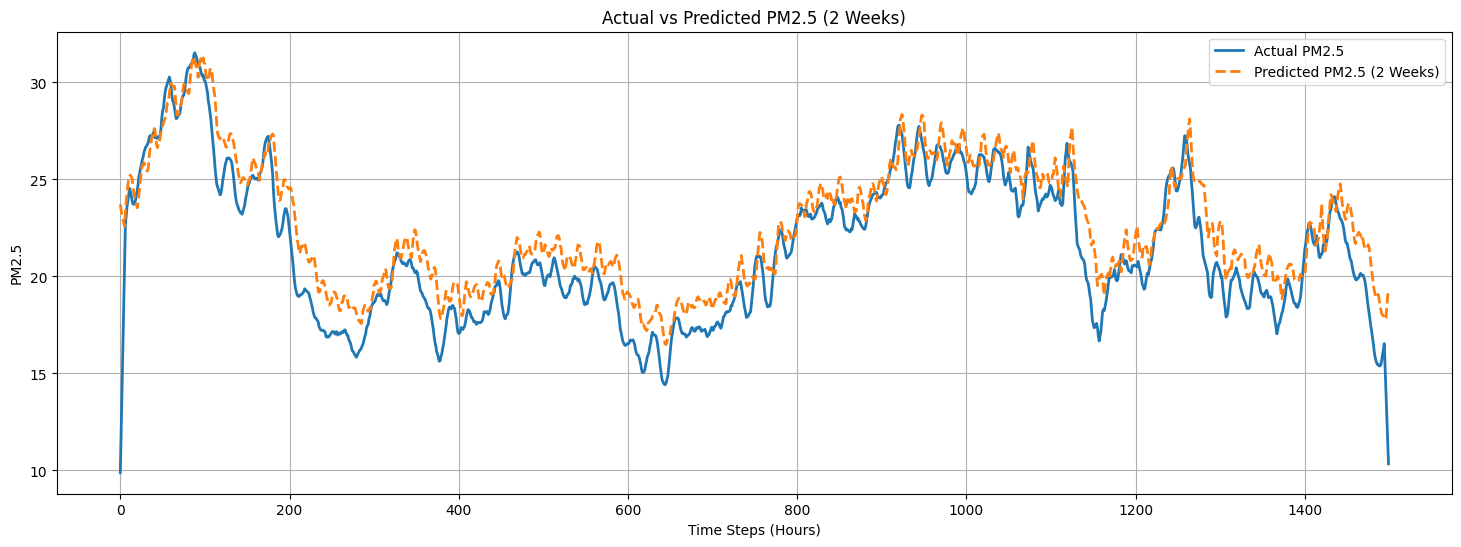

In [6]:
plt.figure(figsize=(18,6))

plt.plot(
    y_actual_smooth,
    label="Actual PM2.5",
    linewidth=2
)

plt.plot(
    y_pred_1500,
    label="Predicted PM2.5 (2 Weeks)",
    linestyle="--",
    linewidth=2
)

plt.title("Actual vs Predicted PM2.5 (2 Weeks)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)


plt.savefig(
    "PM25_Actual_vs_Predicted_2Weeks_1500points.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
